In [1]:
# 让notebook宽屏显示
from IPython.display import display, HTML
display(HTML('<style>.container{width:100% !important;}</style>'))

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm,tqdm_notebook 
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

from catboost import CatBoostClassifier
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from scipy import sparse
import warnings
import time
import sys
import os
import gc
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',None)
pd.set_option('max_colwidth',100)

/Users/limeng/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### 数据读取

In [3]:
train = pd.read_csv('train.csv')
test =  pd.read_csv('test.csv')
(train.shape,test.shape)

((201917, 6), (123623, 5))

In [4]:
%%time
history_transaction = pd.read_csv('historical_transactions.csv', header=0)
new_transaction = pd.read_csv('new_merchant_transactions.csv', header=0)

new_transactions = pd.read_csv('new_merchant_transactions.csv', parse_dates=['purchase_date'])#对时间序列特征进行解析，将数据中的时间字符串转换成⽇期格式
historical_transactions = pd.read_csv('historical_transactions.csv', parse_dates=['purchase_date'])
for col in ['authorized_flag', 'category_1']:
    historical_transactions[col] = historical_transactions[col].map({'Y':1, 'N':0})
    new_transactions[col]        = new_transactions[col].map({'Y':1, 'N':0})
    
(history_transaction.shape,new_transaction.shape)#((29112361, 14), (1963031, 14))

CPU times: user 1min 47s, sys: 49.7 s, total: 2min 37s
Wall time: 2min 55s


((29112361, 14), (1963031, 14))

#### 内存管理

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

#### 1.数据预处理

In [6]:
%%time
## 加载训练集，测试集，基本处理
target = train['target']
for df in [train,test]:
    df['first_active_month']=pd.to_datetime(df['first_active_month'])
    df['year']=df['first_active_month'].dt.year
    df['elapsed_time'] = (datetime.date(2018,3, 1) - df['first_active_month'].dt.date).dt.days
    df['weekofyear'] = df['first_active_month'].dt.weekofyear
    df['dayofyear'] = df['first_active_month'].dt.dayofyear
    df['month'] = df['first_active_month'].dt.month
    
## 交易表合并train test，增加特征‘第一次激活时间(月份)
train_test = pd.concat([train[['card_id','first_active_month']], test[['card_id','first_active_month']] ], axis=0, ignore_index=True)
historical_transactions   = historical_transactions.merge(train_test[['card_id','first_active_month']], on=['card_id'], how='left')
new_transactions = new_transactions.merge(train_test[['card_id','first_active_month']], on=['card_id'], how='left')

CPU times: user 9.31 s, sys: 7.57 s, total: 16.9 s
Wall time: 19.2 s


- 对historical_transactions/new_transactions数据进行处理

In [7]:
def month_trans(x): 
    return x // 30

def week_trans(x): 
    return x // 7

## 交易表预处理
def get_expand_common(df_):
    df = df_.copy()
    
    df['category_2'].fillna(1.0,inplace=True)#缺失值填充
    df['category_3'].fillna('A',inplace=True)#缺失值填充
    df['category_3'] = df['category_3'].map({'A':0, 'B':1, 'C':2})#编码转换
    df['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)#'merchant_id'的众数是M_ID_00a6ca8a8a,用众数填补缺失值
    
    #对分期付款次数进行处理
    df['installments'].replace(-1, np.nan,inplace=True)#用nan替换-1
    df['installments'].replace(999, np.nan,inplace=True)#分999异常数据
    df['installments'].replace(0, 1,inplace=True)#分期付款，0即不做分期，一期
    
    df['purchase_amount'] = np.round(df['purchase_amount'] / 0.00150265118 + 497.06,8)#data* std + mean
    df['purchase_amount'] = df.purchase_amount.apply(lambda x: np.round(x))#标准化后的付款金额,恢复
    
    df['purchase_date']          = pd.to_datetime(df['purchase_date']) 
    df['first_active_month']     = pd.to_datetime(df['first_active_month']) 
    df['purchase_hour']          = df['purchase_date'].dt.hour
    df['year']                   = df['purchase_date'].dt.year
    df['month']                  = df['purchase_date'].dt.month
    df['day']                    = df['purchase_date'].dt.day
    df['hour']                   = df['purchase_date'].dt.hour
    df['weekofyear']             = df['purchase_date'].dt.weekofyear
    df['dayofweek']              = df['purchase_date'].dt.dayofweek
    df['weekend']                = (df.purchase_date.dt.weekday >=5).astype(int) 
    df                           = df.sort_values(['card_id','purchase_date']) #排序
    df['purchase_date_floorday'] = df['purchase_date'].dt.floor('d')  #删除day后面的时间（小时/分钟/秒）保留到日
    
    # 距离激活时间的相对时间间隔,0, 1,2,3,...,max-act
    df['purchase_day_since_active_day']   = df['purchase_date_floorday'] - df['first_active_month']  
    df['purchase_day_since_active_day']   = df['purchase_day_since_active_day'].dt.days  #付款时间距离激活时间，天
    df['purchase_month_since_active_day'] = df['purchase_day_since_active_day']//30 #付款时间距离激活时间，月
    df['purchase_week_since_active_day']  = df['purchase_day_since_active_day']//7 #付款时间距离激活时间，周
    
    # 用户付款距离最后一天时间的相对时间间隔,0,1,2,3,...,max-act
    ht_card_id_gp = df.groupby('card_id')
    df['purchase_day_since_reference_day']   =  ht_card_id_gp['purchase_date_floorday'].transform('max') - df['purchase_date_floorday']
    df['purchase_day_since_reference_day']   =  df['purchase_day_since_reference_day'].dt.days
    # 一个粗粒度的特征(距离最近购买过去了几周，几月)
    df['purchase_week_since_reference_day']  = df['purchase_day_since_reference_day'].agg(week_trans).values
    df['purchase_month_since_reference_day'] = df['purchase_day_since_reference_day'].agg(month_trans).values
    #用户付款间隔时间
    df['purchase_day_diff']   =  df['purchase_date_floorday'].shift()
    df['purchase_day_diff']   =  df['purchase_date_floorday'].values - df['purchase_day_diff'].values
    df['purchase_day_diff']   =  df['purchase_day_diff'].dt.days
    df['purchase_week_diff']  =  df['purchase_day_diff'].agg(week_trans).values
    df['purchase_month_diff'] =  df['purchase_day_diff'].agg(month_trans).values 
    ##不明白？？？？
    df['purchase_amount_ddgd_98']  = df['purchase_amount'].values * df['purchase_day_since_reference_day'].apply(lambda x:0.98**x).values
    df['purchase_amount_ddgd_99']  = df['purchase_amount'].values * df['purchase_day_since_reference_day'].apply(lambda x:0.99**x).values    
    df['purchase_amount_wdgd_96']  = df['purchase_amount'].values * df['purchase_week_since_reference_day'].apply(lambda x:0.96**x).values 
    df['purchase_amount_wdgd_97']  = df['purchase_amount'].values * df['purchase_week_since_reference_day'].apply(lambda x:0.97**x).values 
    df['purchase_amount_mdgd_90']  = df['purchase_amount'].values * df['purchase_month_since_reference_day'].apply(lambda x:0.9**x).values
    df['purchase_amount_mdgd_80']  = df['purchase_amount'].values * df['purchase_month_since_reference_day'].apply(lambda x:0.8**x).values 
    
    df = reduce_mem_usage(df)
    
    return df

In [8]:
%%time
## 交易表预处理
historical_transactions = get_expand_common(historical_transactions)
new_transactions        = get_expand_common(new_transactions)

Mem. usage decreased to 3192.83 Mb (64.1% reduction)
Mem. usage decreased to 211.55 Mb (64.7% reduction)
CPU times: user 4min 34s, sys: 45.8 s, total: 5min 20s
Wall time: 5min 24s


In [9]:
historical_transactions.shape

(29112361, 39)

In [10]:
## 构造基本统计特征
def aggregate_transactions(df_, prefix): 
    
    df = df_.copy()
    
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30#付款时间距离当前时间间隔，按月统计
    df['month_diff'] = df['month_diff'].astype(int)
    #df['month_diff'] += df['month_lag']
    
    df['price'] = df['purchase_amount'] / df['installments']#总金额/分期付款次数=平均每次付款金额
    df['duration'] = df['purchase_amount'] * df['month_diff']
    df['amount_month_ratio'] = df['purchase_amount'] / df['month_diff']
    
    #df.loc[:, 'purchase_date'] = pd.DatetimeIndex(df['purchase_date']).astype(np.int64) * 1e-9###???
    
    agg_func = {
        'category_1':      ['mean'],
        'category_2':      ['mean'],
        'category_3':      ['mean'],
        'installments':    ['mean', 'max', 'min', 'std'],
        'month_lag':       ['nunique', 'mean', 'max', 'min', 'std'],
        'month':           ['nunique', 'mean', 'max', 'min', 'std'],
        'hour':            ['nunique', 'mean', 'max', 'min', 'std'],
        'weekofyear':      ['nunique', 'mean', 'max', 'min', 'std'],
        'dayofweek':       ['nunique', 'mean'],
        'weekend':         ['mean'],
        'year':            ['nunique'],
        'card_id':         ['size','count'],
        'purchase_date':   ['max', 'min'],
        ###
        'price':             ['mean','max','min','std'],
        'duration':          ['mean','min','max','std','skew'],
        'amount_month_ratio':['mean','min','max','std','skew'],
        } 
    
    for col in ['category_2','category_3']:
        df[col+'_mean'] = df.groupby([col])['purchase_amount'].transform('mean')
        agg_func[col+'_mean'] = ['mean']
    
    agg_df = df.groupby(['card_id']).agg(agg_func)
    agg_df.columns = [prefix + '_'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(drop=False, inplace=True)
  
    return agg_df

In [11]:
%%time
## 构造基本统计特征
print('generate statistics features...')
auth_base_stat = aggregate_transactions(historical_transactions[historical_transactions['authorized_flag']==1], prefix='auth_')#授权信息公开
print('generate statistics features...')
hist_base_stat = aggregate_transactions(historical_transactions[historical_transactions['authorized_flag']==0], prefix='hist_')#未授权
print('generate statistics features...')
new_base_stat  = aggregate_transactions(new_transactions, prefix='new_')

generate statistics features...
generate statistics features...
generate statistics features...
CPU times: user 4min, sys: 16.8 s, total: 4min 17s
Wall time: 4min 20s


In [12]:
auth_base_stat.shape

(325540, 52)

In [13]:
hist_base_stat['hist_purchase_date_max_min']=(hist_base_stat['hist_purchase_date_max']-hist_base_stat['hist_purchase_date_min']).dt.days
auth_base_stat['auth_purchase_date_max_min']=(auth_base_stat['auth_purchase_date_max']-auth_base_stat['auth_purchase_date_min']).dt.days
new_base_stat['new_purchase_date_max_min']  =(new_base_stat['new_purchase_date_max']-new_base_stat['new_purchase_date_min']).dt.days

hist_base_stat['hist_purchase_date_max_day']  =hist_base_stat['hist_purchase_date_max'].dt.day
hist_base_stat['hist_purchase_date_max_month']=hist_base_stat['hist_purchase_date_max'].dt.month
auth_base_stat['auth_purchase_date_max_day']  =auth_base_stat['auth_purchase_date_max'].dt.day
auth_base_stat['auth_purchase_date_max_month']=auth_base_stat['auth_purchase_date_max'].dt.month
new_base_stat['new_purchase_date_max_day']    =new_base_stat['new_purchase_date_max'].dt.day
new_base_stat['new_purchase_date_max_month']  =new_base_stat['new_purchase_date_max'].dt.month

hist_base_stat['hist_purchase_date_min_day']  =hist_base_stat['hist_purchase_date_min'].dt.day
hist_base_stat['hist_purchase_date_min_month']=hist_base_stat['hist_purchase_date_min'].dt.month
auth_base_stat['auth_purchase_date_min_day']  =auth_base_stat['auth_purchase_date_min'].dt.day
auth_base_stat['auth_purchase_date_min_month']=auth_base_stat['auth_purchase_date_min'].dt.month
new_base_stat['new_purchase_date_min_day']    =new_base_stat['new_purchase_date_min'].dt.day
new_base_stat['new_purchase_date_min_month']  =new_base_stat['new_purchase_date_min'].dt.month

In [14]:
hist_base_stat.drop(columns=['hist_purchase_date_max','hist_purchase_date_min'],inplace=True)
auth_base_stat.drop(columns=['auth_purchase_date_max','auth_purchase_date_min'],inplace=True)
new_base_stat.drop(columns=['new_purchase_date_max','new_purchase_date_min'],inplace=True)

In [15]:
auth_base_stat.shape

(325540, 55)

In [16]:
%%time
def get_quantile(x, percentiles = [0.1, 0.25, 0.75, 0.9]):
    x_len = len(x)
    x = np.sort(x)
    sts_feas = []  
    for per_ in percentiles:
        if per_ == 1:
            sts_feas.append(x[x_len - 1]) 
        else:
            sts_feas.append(x[int(x_len * per_)]) 
    return sts_feas 

def get_cardf_tran(df_, month = 3, prefix = '_'):
    
    df = df_.copy() 
    if prefix == 'hist_cardf_':
        df['month_to_now']  =  (datetime.date(2018, month, 1) - df['purchase_date_floorday'].dt.date).dt.days
        #历史数据，用2018年3月作为当前时间，付款时间到当前时间的天数
    df['month_diff'] = ((datetime.datetime.today() - df['purchase_date']).dt.days)//30#距当前时间间隔，按月统计
    df['month_diff'] = df['month_diff'].astype(int)
    df['month_diff'] += df['month_lag']#加上距离2018年2月的月差？？
    
    print('*'*30,'Part1, whole data','*'*30)
    cardid_features = pd.DataFrame()
    cardid_features['card_id'] = df['card_id'].unique()   
    print( '*' * 30, 'Traditional Features', '*' * 30)
    ht_card_id_gp = df.groupby('card_id') 
    cardid_features['card_id_cnt'] = ht_card_id_gp['authorized_flag'].count().values#是否授权的数量
    
    if  prefix == 'hist_cardf_':
        cardid_features['card_id_isau_mean'] = ht_card_id_gp['authorized_flag'].mean().values
        cardid_features['card_id_isau_sum'] = ht_card_id_gp['authorized_flag'].sum().values 
    
    cardid_features['month_diff_mean']   = ht_card_id_gp['month_diff'].mean().values
    cardid_features['month_diff_median'] = ht_card_id_gp['month_diff'].median().values
    
    if prefix == 'hist_cardf_':
        cardid_features['reference_day']           =  ht_card_id_gp['purchase_date_floorday'].max().values#付款时间最大，即最后一次付款
        cardid_features['first_day']               =  ht_card_id_gp['purchase_date_floorday'].min().values #第一次付款时间
        cardid_features['activation_day']          =  ht_card_id_gp['first_active_month'].max().values#激活的日期
       
        # first to activation day
        cardid_features['first_to_activation_day']  =  (cardid_features['first_day'] - cardid_features['activation_day']).dt.days#从激活到使用付款时间天数，单位天
        # activation to reference day 
        cardid_features['activation_to_reference_day']  =  (cardid_features['reference_day'] - cardid_features['activation_day']).dt.days#从激活到最后一次付款的间隔
        # first to last day 
        cardid_features['first_to_reference_day']  =  (cardid_features['reference_day'] - cardid_features['first_day']).dt.days#最后一次付款和第一次付款间隔
        # reference day to now  
        cardid_features['reference_day_to_now']  =  (datetime.date(2018, month, 1) - cardid_features['reference_day'].dt.date).dt.days #最后一次付款距离统计时间的间隔
        # first day to now
        cardid_features['first_day_to_now']  =  (datetime.date(2018, month, 1) - cardid_features['first_day'].dt.date).dt.days #第一次付款距离统计时间的间隔
        
        print('card_id(month_lag, min to reference day):min')
        cardid_features['card_id_month_lag_min'] = ht_card_id_gp['month_lag'].agg('min').values   #每个用户距离2018年2月间隔时间最长的时间
        # is_purchase_before_activation,first_to_reference_day_divide_activation_to_reference_day
        cardid_features['is_purchase_before_activation'] = cardid_features['first_to_activation_day'] < 0 #在激活之前使用支付的用户
        cardid_features['is_purchase_before_activation'] = cardid_features['is_purchase_before_activation'].astype(int)
        cardid_features['first_to_reference_day_divide_activation_to_reference_day'] = cardid_features['first_to_reference_day']  / (cardid_features['activation_to_reference_day']  + 0.01)
        cardid_features['days_per_count'] = cardid_features['first_to_reference_day'].values / cardid_features['card_id_cnt'].values#？？？？
   
    if prefix == 'new_cardf_':#和上面做一样的处理
        print(' Eight time features, ') 
        cardid_features['reference_day']           =  ht_card_id_gp['reference_day'].last().values
        cardid_features['first_day']               =  ht_card_id_gp['purchase_date_floorday'].min().values 
        cardid_features['last_day']                =  ht_card_id_gp['purchase_date_floorday'].max().values
        cardid_features['activation_day']          =  ht_card_id_gp['first_active_month'].max().values
        # reference to first day
        cardid_features['reference_day_to_first_day']  =  (cardid_features['first_day'] - cardid_features['reference_day']).dt.days
        # reference to last day
        cardid_features['reference_day_to_last_day']  =  (cardid_features['last_day'] - cardid_features['reference_day']).dt.days  
        # first to last day 
        cardid_features['first_to_last_day']  =  (cardid_features['last_day'] - cardid_features['first_day']).dt.days
        # activation to first day 
        cardid_features['activation_to_first_day']  =  (cardid_features['first_day'] - cardid_features['activation_day']).dt.days
        # activation to first day 
        cardid_features['activation_to_last_day']  =  (cardid_features['last_day'] - cardid_features['activation_day']).dt.days
        # last day to now  
        cardid_features['reference_day_to_now']  =  (datetime.date(2018, month, 1) - cardid_features['reference_day'].dt.date).dt.days 
        # first day to now
        cardid_features['first_day_to_now']  =  (datetime.date(2018, month, 1) - cardid_features['first_day'].dt.date).dt.days 
        
        print('card_id(month_lag, min to reference day):min')
        cardid_features['card_id_month_lag_max'] = ht_card_id_gp['month_lag'].agg('max').values  
        cardid_features['first_to_last_day_divide_reference_to_last_day'] = cardid_features['first_to_last_day']  / (cardid_features['reference_day_to_last_day']  + 0.01)
        cardid_features['days_per_count'] = cardid_features['first_to_last_day'].values / cardid_features['card_id_cnt'].values#？？？
    
    for f in ['reference_day', 'first_day', 'last_day', 'activation_day']:
        try:
            del cardid_features[f]
        except:
            print(f, '不存在！！！')#内存处理

    print('card id(city_id,installments,merchant_category_id,.......):nunique, cnt/nunique') 
    for col in tqdm_notebook(['category_1','category_2','category_3','state_id','city_id','installments','merchant_id', 'merchant_category_id','subsector_id','month_lag','purchase_date_floorday']):
        cardid_features['card_id_%s_nunique'%col]            =  ht_card_id_gp[col].nunique().values#每个用户不同特征属性的数量
        cardid_features['card_id_cnt_divide_%s_nunique'%col] =  cardid_features['card_id_cnt'].values / cardid_features['card_id_%s_nunique'%col].values
         
    print('card_id(purchase_amount & degrade version ):mean,sum,std,median,quantile(10,25,75,90)') 
    for col in tqdm_notebook(['installments','purchase_amount','purchase_amount_ddgd_98','purchase_amount_ddgd_99','purchase_amount_wdgd_96','purchase_amount_wdgd_97','purchase_amount_mdgd_90','purchase_amount_mdgd_80']):
        if col =='purchase_amount':
            for opt in ['sum','mean','std','median','max','min']:
                cardid_features['card_id_' +col+ '_' + opt] = ht_card_id_gp[col].agg(opt).values
            
            cardid_features['card_id_' +col+ '_range'] =  cardid_features['card_id_' +col+ '_max'].values - cardid_features['card_id_' +col+ '_min'].values
            percentiles = ht_card_id_gp[col].apply(lambda x:get_quantile(x,percentiles = [0.025, 0.25, 0.75, 0.975])) 

            cardid_features[col + '_2.5_quantile']  = percentiles.map(lambda x:x[0]).values
            cardid_features[col + '_25_quantile'] = percentiles.map(lambda x:x[1]).values
            cardid_features[col + '_75_quantile'] = percentiles.map(lambda x:x[2]).values
            cardid_features[col + '_97.5_quantile'] = percentiles.map(lambda x:x[3]).values
            cardid_features['card_id_' +col+ '_range2'] =  cardid_features[col+ '_97.5_quantile'].values - cardid_features[col+ '_2.5_quantile'].values
            del cardid_features[col + '_2.5_quantile'],cardid_features[col + '_97.5_quantile']
            gc.collect()
        else:
            for opt in ['sum']:
                cardid_features['card_id_' +col+ '_' + opt] = ht_card_id_gp[col].agg(opt).values          
    #四分位？？？？
    print( '*' * 30, 'Pivot Features', '*' * 30)
    print('Count  Pivot') #purchase_month_since_reference_day(可能和month_lag重复),百分比降分,暂时忽略 (dayofweek,merchant_cate,state_id)作用不大installments
    for pivot_col in tqdm_notebook(['category_1','category_2','category_3','month_lag','subsector_id','weekend']): #'city_id',,
    
        tmp     = df.groupby(['card_id',pivot_col])['merchant_id'].count().to_frame(pivot_col + '_count')
        tmp.reset_index(inplace =True)  
         
        tmp_pivot = pd.pivot_table(data=tmp,index = 'card_id',columns=pivot_col,values=pivot_col + '_count',fill_value=0)
        tmp_pivot.columns = [tmp_pivot.columns.names[0] + '_cnt_pivot_'+ str(col) for col in tmp_pivot.columns]
        tmp_pivot.reset_index(inplace = True)
        cardid_features = cardid_features.merge(tmp_pivot, on = 'card_id', how='left')
      
        if  pivot_col!='weekend' and  pivot_col!='installments':
            tmp            = df.groupby(['card_id',pivot_col])['purchase_date_floorday'].nunique().to_frame(pivot_col + '_purchase_date_floorday_nunique') 
            tmp1           = df.groupby(['card_id'])['purchase_date_floorday'].nunique().to_frame('purchase_date_floorday_nunique') 
            tmp.reset_index(inplace =True)  
            tmp1.reset_index(inplace =True)   
            tmp  = tmp.merge(tmp1, on ='card_id', how='left')
            tmp[pivot_col + '_day_nunique_pct'] = tmp[pivot_col + '_purchase_date_floorday_nunique'].values / tmp['purchase_date_floorday_nunique'].values
         
            tmp_pivot = pd.pivot_table(data=tmp,index = 'card_id',columns=pivot_col,values=pivot_col + '_day_nunique_pct',fill_value=0)
            tmp_pivot.columns = [tmp_pivot.columns.names[0] + '_day_nunique_pct_'+ str(col) for col in tmp_pivot.columns]
            tmp_pivot.reset_index(inplace = True)
            cardid_features = cardid_features.merge(tmp_pivot, on = 'card_id', how='left')
    

    
    return cardid_features

print('auth...')
authorized_transactions = historical_transactions.loc[historical_transactions['authorized_flag'] == 1]
auth_cardf_tran = get_cardf_tran(authorized_transactions, 3, prefix='auth_cardf_')

print('hist...')
hist_cardf_tran = get_cardf_tran(historical_transactions, 3, prefix='hist_cardf_')

print('new...')
reference_days = historical_transactions.groupby('card_id')['purchase_date'].last().to_frame('reference_day')
reference_days.reset_index(inplace = True)
new_transactions = new_transactions.merge(reference_days, on ='card_id', how='left')
new_cardf_tran  = get_cardf_tran(new_transactions, 5, prefix='new_cardf_')

auth...
****************************** Part1, whole data ******************************
****************************** Traditional Features ******************************
reference_day 不存在！！！
first_day 不存在！！！
last_day 不存在！！！
activation_day 不存在！！！
card id(city_id,installments,merchant_category_id,.......):nunique, cnt/nunique


  0%|          | 0/11 [00:00<?, ?it/s]

card_id(purchase_amount & degrade version ):mean,sum,std,median,quantile(10,25,75,90)


  0%|          | 0/8 [00:00<?, ?it/s]

****************************** Pivot Features ******************************
Count  Pivot


  0%|          | 0/6 [00:00<?, ?it/s]

hist...
****************************** Part1, whole data ******************************
****************************** Traditional Features ******************************
card_id(month_lag, min to reference day):min
last_day 不存在！！！
card id(city_id,installments,merchant_category_id,.......):nunique, cnt/nunique


  0%|          | 0/11 [00:00<?, ?it/s]

card_id(purchase_amount & degrade version ):mean,sum,std,median,quantile(10,25,75,90)


  0%|          | 0/8 [00:00<?, ?it/s]

****************************** Pivot Features ******************************
Count  Pivot


  0%|          | 0/6 [00:00<?, ?it/s]

new...
****************************** Part1, whole data ******************************
****************************** Traditional Features ******************************
 Eight time features, 
card_id(month_lag, min to reference day):min
card id(city_id,installments,merchant_category_id,.......):nunique, cnt/nunique


  0%|          | 0/11 [00:00<?, ?it/s]

card_id(purchase_amount & degrade version ):mean,sum,std,median,quantile(10,25,75,90)


  0%|          | 0/8 [00:00<?, ?it/s]

****************************** Pivot Features ******************************
Count  Pivot


  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 8min 7s, sys: 1min 16s, total: 9min 24s
Wall time: 9min 30s


In [17]:
auth_cardf_tran.shape#325540 rows × 175 columns

(325540, 175)

In [18]:
%%time
print(train.shape)
print(test.shape)
## 合并到训练集和测试集
print('#_____基础统计特征')
train = pd.merge(train, auth_base_stat, on='card_id', how='left')
test  = pd.merge(test,  auth_base_stat, on='card_id', how='left')
train = pd.merge(train, hist_base_stat, on='card_id', how='left')
test  = pd.merge(test,  hist_base_stat, on='card_id', how='left')
train = pd.merge(train, new_base_stat , on='card_id', how='left')
test  = pd.merge(test,  new_base_stat , on='card_id', how='left')
print(train.shape)
print(test.shape)
print('#_____全局cardid特征')
train = pd.merge(train, auth_cardf_tran, on='card_id', how='left')
test  = pd.merge(test,  auth_cardf_tran, on='card_id', how='left')
train = pd.merge(train, hist_cardf_tran, on='card_id', how='left')
test  = pd.merge(test,  hist_cardf_tran, on='card_id', how='left')
train = pd.merge(train, new_cardf_tran , on='card_id', how='left')
test  = pd.merge(test,  new_cardf_tran , on='card_id', how='left')
print(train.shape)
print(test.shape)

(201917, 11)
(123623, 10)
#_____基础统计特征
(201917, 173)
(123623, 172)
#_____全局cardid特征
(201917, 692)
(123623, 691)
CPU times: user 10.7 s, sys: 8.19 s, total: 18.9 s
Wall time: 19 s


In [19]:
for df in (train,test):
    df.drop(columns='first_active_month',inplace=True)

In [20]:
train.shape#201917 rows × 691 columns

(201917, 691)

In [21]:
train.to_csv('all_train_features5.1.csv',index=False)
test.to_csv('all_test_features5.1.csv',index=False)

#### 特征提取

- filter 特征筛选

In [22]:
# 提取特征名称
features = train.columns.tolist()
features.remove("card_id")
features.remove("target")
featureSelect = features[:]

In [23]:
# 计算相关系数
corr = []
for fea in featureSelect:
    corr.append(abs(train[[fea, 'target']].fillna(0).corr().values[0][1]))
    
# 取top500的特征进行建模，具体数量可选
se = pd.Series(corr, index=featureSelect).sort_values(ascending=False)
feature_select = ['card_id'] + se[:500].index.tolist()

# 输出结果
train_RF = train[feature_select + ['target']]
test_RF = test[feature_select]
train_RF.shape

(201917, 502)

- wrapper特征筛选

In [24]:
def feature_select_wrapper(train, test):
    """
    lgm特征重要性筛选函数
    :param train:训练数据集
    :param test:测试数据集
    :return:特征筛选后的训练集和测试集
    """
    
    # Part 1.划分特征名称，删除ID列和标签列
    print('feature_select_wrapper...')
    label = 'target'
    features = train.columns.tolist()
    features.remove('card_id')
    features.remove('target')

    # Step 2.配置lgb参数
    # 模型参数
    params_initial = {
        'num_leaves': 31,
        'learning_rate': 0.1,
        'boosting': 'gbdt',
        'min_child_samples': 20,
        'bagging_seed': 2020,
        'bagging_fraction': 0.7,
        'bagging_freq': 1,
        'feature_fraction': 0.7,
        'max_depth': -1,
        'metric': 'rmse',
        'reg_alpha': 0,
        'reg_lambda': 1,
        'objective': 'regression'
    }
    # 控制参数
    # 提前验证迭代效果或停止
    ESR = 30
    # 迭代次数
    NBR = 10000
    # 打印间隔
    VBE = 50
    
    # Part 3.交叉验证过程
    # 实例化评估器
    kf = KFold(n_splits=5, random_state=2020, shuffle=True)
    # 创建空容器
    fse = pd.Series(0, index=features)
    
    for train_part_index, eval_index in kf.split(train[features], train[label]):
        # 封装训练数据集
        train_part = lgb.Dataset(train[features].loc[train_part_index],
                                 train[label].loc[train_part_index])
        # 封装验证数据集
        eval = lgb.Dataset(train[features].loc[eval_index],
                           train[label].loc[eval_index])
        # 在训练集上进行训练，并同时进行验证
        bst = lgb.train(params_initial, train_part, num_boost_round=NBR,
                        valid_sets=[train_part, eval],
                        valid_names=['train', 'valid'],
                        early_stopping_rounds=ESR, verbose_eval=VBE)
        # 输出特征重要性计算结果，并进行累加
        fse += pd.Series(bst.feature_importance(), features)
    
    # Part 4.选择最重要的300个特征
    feature_select = ['card_id'] + fse.sort_values(ascending=False).index.tolist()[:300]
    print('done')
    return train[feature_select + ['target']], test[feature_select]

In [25]:
train_LGBM, test_LGBM =feature_select_wrapper(train_RF, test_RF)

feature_select_wrapper...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.728880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75493
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 500
[LightGBM] [Info] Start training from score -0.390986
Training until validation scores don't improve for 30 rounds
[50]	train's rmse: 3.40864	valid's rmse: 3.67372
[100]	train's rmse: 3.27459	valid's rmse: 3.66897
Early stopping, best iteration is:
[75]	train's rmse: 3.33758	valid's rmse: 3.66658
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.609379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 75457
[LightGBM] [Info] Number of data points in the train set: 161533, number of used features: 500
[LightGBM] [Info] Start training from score -0.396781
Training until validation scores

In [26]:
train_LGBM.shape

(201917, 302)

In [27]:
train_LGBM.columns

Index(['card_id', 'reference_day_to_last_day', 'new_purchase_date_max_day',
       'month_diff_mean_y', 'month_diff_mean_x', 'month_lag_day_nunique_pct_1',
       'card_id_cnt_divide_merchant_id_nunique_y', 'new_weekofyear_std',
       'card_id_isau_mean', 'reference_day_to_now_x',
       ...
       'subsector_id_day_nunique_pct_32_y', 'hist_installments_max',
       'auth_category_2_mean', 'card_id_city_id_nunique_y',
       'new_category_2_mean_mean', 'subsector_id_cnt_pivot_36_y',
       'hist_purchase_date_max_month',
       'card_id_cnt_divide_merchant_category_id_nunique',
       'card_id_cnt_divide_subsector_id_nunique', 'target'],
      dtype='object', length=302)

## 建模

In [28]:
#区分异常值
train_LGBM['outliers'] = 0
train_LGBM.loc[train_LGBM['target'] < -30, 'outliers'] = 1
train_LGBM['outliers'].value_counts()

0    199710
1      2207
Name: outliers, dtype: int64

In [29]:
def train_model(X, X_test, y, params, folds, model_type='lgb', eval_type='regression'):
    oof = np.zeros(X.shape[0])
    predictions = np.zeros(X_test.shape[0])
    scores = []
    for fold_n, (trn_idx, val_idx) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        
        if model_type == 'lgb':
            trn_data = lgb.Dataset(X[trn_idx], y[trn_idx])
            val_data = lgb.Dataset(X[val_idx], y[val_idx])
            clf = lgb.train(params, trn_data, num_boost_round=20000, 
                            valid_sets=[trn_data, val_data], 
                            verbose_eval=100, early_stopping_rounds=300)
            oof[val_idx] = clf.predict(X[val_idx], num_iteration=clf.best_iteration)
            predictions += clf.predict(X_test, num_iteration=clf.best_iteration) / folds.n_splits
        
        if model_type == 'xgb':
            trn_data = xgb.DMatrix(X[trn_idx], y[trn_idx])
            val_data = xgb.DMatrix(X[val_idx], y[val_idx])
            watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
            clf = xgb.train(dtrain=trn_data, num_boost_round=20000, 
                            evals=watchlist, early_stopping_rounds=200, 
                            verbose_eval=100, params=params)
            oof[val_idx] = clf.predict(xgb.DMatrix(X[val_idx]), ntree_limit=clf.best_ntree_limit)
            predictions += clf.predict(xgb.DMatrix(X_test), ntree_limit=clf.best_ntree_limit) / folds.n_splits
        
        if (model_type == 'cat') and (eval_type == 'regression'):
            clf = CatBoostRegressor(iterations=20000, eval_metric='RMSE', **params)
            clf.fit(X[trn_idx], y[trn_idx], 
                    eval_set=(X[val_idx], y[val_idx]),
                    cat_features=[], use_best_model=True, verbose=100)
            oof[val_idx] = clf.predict(X[val_idx])
            predictions += clf.predict(X_test) / folds.n_splits
            
        if (model_type == 'cat') and (eval_type == 'binary'):
            clf = CatBoostClassifier(iterations=20000, eval_metric='Logloss', **params)
            clf.fit(X[trn_idx], y[trn_idx], 
                    eval_set=(X[val_idx], y[val_idx]),
                    cat_features=[], use_best_model=True, verbose=100)
            oof[val_idx] = clf.predict_proba(X[val_idx])[:,1]
            predictions += clf.predict_proba(X_test)[:,1] / folds.n_splits
        print(predictions)
        if eval_type == 'regression':
            scores.append(mean_squared_error(oof[val_idx], y[val_idx])**0.5)
        if eval_type == 'binary':
            scores.append(log_loss(y[val_idx], oof[val_idx]))
        
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    return oof, predictions, scores

In [30]:
# 提取特征名称
fea_cols = train_LGBM.columns.tolist()
fea_cols.remove("outliers")
fea_cols.remove("target")
fea_cols.remove("card_id")

fea_cols = fea_cols[:]

In [32]:
## 获取非异常值的index
normal_index = train_LGBM[train_LGBM['outliers']==0].index.tolist()
## without outliers
ntrain_LGBM = train_LGBM[train_LGBM['outliers'] == 0]

target        = train_LGBM['target'].values
ntarget       = ntrain_LGBM['target'].values
target_binary = train_LGBM['outliers'].values
###
y_train        = target
y_ntrain       = ntarget
y_train_binary = target_binary

print('train_LGBM:',train_LGBM.shape)
print('ntrain_LGBM:',ntrain_LGBM.shape)

train_LGBM: (201917, 303)
ntrain_LGBM: (199710, 303)


### lightGBM单模型

In [33]:
#### lgb
lgb_params = {'num_leaves': 63,
             'min_data_in_leaf': 32, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.01,
             "min_child_samples": 20,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1}
folds = KFold(n_splits=5, shuffle=True, random_state=4096)
X_ntrain = ntrain_LGBM[fea_cols].values
X_train  = train_LGBM[fea_cols].values
X_test   = test_LGBM[fea_cols].values
print('='*10,'回归模型','='*10)
oof_lgb , predictions_lgb , scores_lgb  = train_model(X_train , X_test, y_train, params=lgb_params, folds=folds, model_type='lgb', eval_type='regression')

========== 回归模型 ==========
Fold 0 started at Tue Jun 27 16:52:23 2023
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
Training until validation scores don't improve for 300 rounds
[100]	training's rmse: 3.55044	valid_1's rmse: 3.79047
[200]	training's rmse: 3.41525	valid_1's rmse: 3.7522
[300]	training's rmse: 3.33281	valid_1's rmse: 3.73765
[400]	training's rmse: 3.26598	valid_1's rmse: 3.72971
[500]	training's rmse: 3.21366	valid_1's rmse: 3.72601
[600]	training's rmse: 3.16698	valid_1's rmse: 3.72403
[700]	training's rmse: 3.12606	valid_1's rmse: 3.72321
[800]	training's rmse: 3.08787	valid_1's rmse: 3.7226
[900]	training's rmse: 3.05239	valid_1's rmse: 3.72236
[1000]	training's rmse: 3.01784	valid_1's rmse: 3.72242
[1100]	training's rmse: 2.98521	valid_1's rmse: 3.72227
[1200]	training's rmse: 2.95349	valid_1's rmse: 3.72226
[1300]	training's rmse: 2.9227	valid_1's rmse: 3.72232
[1400]	training's rmse: 2.8934

### lightgbm两阶段建模——分类+回归

In [35]:
print('='*10,'分类模型','='*10)
lgb_params['objective'] = 'binary'
lgb_params['metric']    = 'binary_logloss'
oof_blgb, predictions_blgb, scores_blgb = train_model(X_train , X_test, y_train_binary, params=lgb_params, folds=folds, model_type='lgb', eval_type='binary')

print('='*10,'without outliers 回归模型','='*10)
oof_nlgb, predictions_nlgb, scores_nlgb = train_model(X_ntrain, X_test, y_ntrain, params=lgb_params, folds=folds, model_type='lgb', eval_type='regression')

========== 分类模型 ==========
Fold 0 started at Tue Jun 27 17:07:06 2023
[LightGBM] [Warning] min_data_in_leaf is set=32, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=32
Training until validation scores don't improve for 300 rounds
[100]	training's binary_logloss: 0.0351205	valid_1's binary_logloss: 0.0493618
[200]	training's binary_logloss: 0.0278893	valid_1's binary_logloss: 0.0473264
[300]	training's binary_logloss: 0.0233699	valid_1's binary_logloss: 0.0468558
[400]	training's binary_logloss: 0.0202954	valid_1's binary_logloss: 0.0467687
[500]	training's binary_logloss: 0.0178843	valid_1's binary_logloss: 0.0468998
[600]	training's binary_logloss: 0.0158538	valid_1's binary_logloss: 0.0470737
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.0204261	valid_1's binary_logloss: 0.0467658
[0.0049766  0.00029046 0.00228279 ... 0.00121473 0.00838607 0.00063605]
Fold 1 started at Tue Jun 27 17:08:11 2023
[LightGBM] [Warning] min_data_in_leaf is se

Training until validation scores don't improve for 300 rounds
[100]	training's binary_logloss: 0.644938	valid_1's binary_logloss: 0.650109
[200]	training's binary_logloss: 0.629761	valid_1's binary_logloss: 0.639724
[300]	training's binary_logloss: 0.621377	valid_1's binary_logloss: 0.636153
[400]	training's binary_logloss: 0.614975	valid_1's binary_logloss: 0.63452
[500]	training's binary_logloss: 0.609434	valid_1's binary_logloss: 0.633665
[600]	training's binary_logloss: 0.604344	valid_1's binary_logloss: 0.6333
[700]	training's binary_logloss: 0.599659	valid_1's binary_logloss: 0.633135
[800]	training's binary_logloss: 0.595239	valid_1's binary_logloss: 0.633048
[900]	training's binary_logloss: 0.590955	valid_1's binary_logloss: 0.632942
[1000]	training's binary_logloss: 0.586843	valid_1's binary_logloss: 0.632879
[1100]	training's binary_logloss: 0.58278	valid_1's binary_logloss: 0.632869
[1200]	training's binary_logloss: 0.578702	valid_1's binary_logloss: 0.632811
[1300]	training

In [43]:
oof_lgb  = pd.DataFrame(oof_lgb)
oof_nlgb = pd.DataFrame(oof_nlgb)
oof_blgb = pd.DataFrame(oof_blgb)

predictions_lgb  = pd.DataFrame(predictions_lgb)
predictions_nlgb = pd.DataFrame(predictions_nlgb)
predictions_blgb = pd.DataFrame(predictions_blgb)

### xgb单模型

In [36]:
#### xgb
xgb_params = {'eta':0.05, 'max_leaves':47, 'max_depth':10, 'subsample':0.8, 'colsample_bytree':0.8,
              'min_child_weight':40, 'max_bin':128, 'reg_alpha':2.0, 'reg_lambda':2.0, 
              'objective':'reg:linear', 'eval_metric':'rmse', 'silent': True, 'nthread':4}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
print('='*10,'回归模型','='*10)
oof_xgb , predictions_xgb , scores_xgb  = train_model(X_train , X_test, y_train , params=xgb_params, folds=folds, model_type='xgb', eval_type='regression')

========== 回归模型 ==========
Fold 0 started at Tue Jun 27 17:45:10 2023
[17:45:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[17:45:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:3.91556	valid_data-rmse:3.93408
[100]	train-rmse:3.13183	valid_data-rmse:3.66531
[200]	train-rmse:2.96533	valid_data-rmse:3.67155
[277]	train-rmse:2.84556	valid_data-rmse:3.67684
[-0.53139603 -0.06011124 -0.17067647 ...  0.12345411 -0.66095924
 -0

### xgboost两阶段建模——分类+回归

In [37]:
print('='*10,'without outliers 回归模型','='*10)
oof_nxgb, predictions_nxgb, scores_nxgb = train_model(X_ntrain, X_test, y_ntrain, params=xgb_params, folds=folds, model_type='xgb', eval_type='regression')
print('='*10,'分类模型','='*10)
xgb_params['objective'] = 'binary:logistic'
xgb_params['metric']    = 'binary_logloss'
oof_bxgb, predictions_bxgb, scores_bxgb = train_model(X_train , X_test, y_train_binary, params=xgb_params, folds=folds, model_type='xgb', eval_type='binary')

========== without outliers 回归模型 ==========
Fold 0 started at Tue Jun 27 19:13:26 2023
[19:13:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[19:13:28] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:1.77426	valid_data-rmse:1.77763
[100]	train-rmse:1.36421	valid_data-rmse:1.55587
[200]	train-rmse:1.29844	valid_data-rmse:1.55624
[300]	train-rmse:1.23529	valid_data-rmse:1.55777
[346]	train-rmse:1.20834	valid_data-rmse:1.55887
[-

[100]	train-rmse:0.09619	valid_data-rmse:0.09855
[200]	train-rmse:0.09208	valid_data-rmse:0.09859
[300]	train-rmse:0.08786	valid_data-rmse:0.09879
[333]	train-rmse:0.08650	valid_data-rmse:0.09885
[0.02823057 0.00179138 0.01083992 ... 0.00646939 0.05621463 0.00362073]
Fold 4 started at Tue Jun 27 20:42:50 2023
[20:42:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-37/xgboost/src/learner.cc:627: 
Parameters: { "metric", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:0.47606	valid_data-rmse:0.47610
[100]	train-rmse:0.09554	valid_data-rmse:0.10085
[200]	train-rmse:0.09160	valid_data-rmse:0.10084
[300]	train-rmse:0.08745	valid_data-rmse:0.10088
[351]	train-rmse:0.08528	valid_d

In [39]:
oof_xgb  = pd.DataFrame(oof_xgb)
oof_nxgb = pd.DataFrame(oof_nxgb)
oof_bxgb = pd.DataFrame(oof_bxgb)

predictions_xgb  = pd.DataFrame(predictions_xgb)
predictions_nxgb = pd.DataFrame(predictions_nxgb)
predictions_bxgb = pd.DataFrame(predictions_bxgb)

### catboost单模型

In [40]:

cat_params = {'learning_rate': 0.05, 'depth': 9, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bernoulli',
              'od_type': 'Iter', 'od_wait': 50, 'random_seed': 11, 'allow_writing_files': False}
folds = KFold(n_splits=5, shuffle=True, random_state=18)
print('='*10,'回归模型','='*10)
oof_cat , predictions_cat , scores_cat  = train_model(X_train , X_test, y_train , params=cat_params, folds=folds, model_type='cat', eval_type='regression')

========== 回归模型 ==========
Fold 0 started at Tue Jun 27 20:56:38 2023
0:	learn: 3.8385771	test: 3.8315323	best: 3.8315323 (0)	total: 243ms	remaining: 1h 20m 53s
100:	learn: 3.5847473	test: 3.6444451	best: 3.6444451 (100)	total: 16.2s	remaining: 53m 12s
200:	learn: 3.5203865	test: 3.6325866	best: 3.6325442 (197)	total: 31.4s	remaining: 51m 28s
300:	learn: 3.4739437	test: 3.6289418	best: 3.6289418 (300)	total: 45.9s	remaining: 50m 4s
400:	learn: 3.4325189	test: 3.6269201	best: 3.6267291 (361)	total: 1m	remaining: 49m 11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 3.626729146
bestIteration = 361

Shrink model to first 362 iterations.
[-0.56958383 -0.10221204 -0.21012553 ...  0.1809907  -0.62514173
  0.03503308]
Fold 1 started at Tue Jun 27 20:57:59 2023
0:	learn: 3.8368376	test: 3.8415963	best: 3.8415963 (0)	total: 175ms	remaining: 58m 29s
100:	learn: 3.5672530	test: 3.6635802	best: 3.6635802 (100)	total: 15.8s	remaining: 51m 49s
200:	learn: 3.5049336	test: 3.654272

### catboost两阶段建模——分类+回归

In [41]:
%%time
print('='*10,'without outliers 回归模型','='*10)
oof_ncat, predictions_ncat, scores_ncat = train_model(X_ntrain, X_test, y_ntrain, params=cat_params, folds=folds, model_type='cat', eval_type='regression')
print('='*10,'分类模型','='*10)
oof_bcat, predictions_bcat, scores_bcat = train_model(X_train , X_test, y_train_binary, params=cat_params, folds=folds, model_type='cat', eval_type='binary')

========== without outliers 回归模型 ==========
Fold 0 started at Tue Jun 27 21:15:53 2023
0:	learn: 1.7049600	test: 1.7147981	best: 1.7147981 (0)	total: 179ms	remaining: 59m 34s
100:	learn: 1.5428961	test: 1.5688310	best: 1.5688310 (100)	total: 16.1s	remaining: 52m 42s
200:	learn: 1.5209479	test: 1.5621933	best: 1.5621933 (200)	total: 31.6s	remaining: 51m 51s
300:	learn: 1.5020163	test: 1.5597094	best: 1.5597094 (300)	total: 46.9s	remaining: 51m 12s
400:	learn: 1.4831719	test: 1.5587107	best: 1.5587065 (399)	total: 1m 2s	remaining: 50m 43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.558467294
bestIteration = 431

Shrink model to first 432 iterations.
[-0.07590979 -0.10377912 -0.12984343 ...  0.18658944 -0.17112482
 -0.00260508]
Fold 1 started at Tue Jun 27 21:17:25 2023
0:	learn: 1.7106090	test: 1.6933130	best: 1.6933130 (0)	total: 178ms	remaining: 59m 11s
100:	learn: 1.5467753	test: 1.5508396	best: 1.5508396 (100)	total: 16.1s	remaining: 52m 45s
200:	learn: 1.5245

In [42]:
oof_cat  = pd.DataFrame(oof_cat)
oof_ncat = pd.DataFrame(oof_ncat)
oof_bcat = pd.DataFrame(oof_bcat)

predictions_cat  = pd.DataFrame(predictions_cat)
predictions_ncat = pd.DataFrame(predictions_ncat)
predictions_bcat = pd.DataFrame(predictions_bcat)

## 模型融合

##### 加权融合

In [51]:
sub_df = pd.read_csv('sample_submission.csv')
sub_df["target"] = (predictions_lgb.values.flatten() + predictions_xgb.values.flatten() + predictions_cat.values.flatten()) / 3
sub_df.to_csv('predictions_weight_average.csv', index=False)

##### stacking

In [52]:
def stack_model(oof_1, oof_2, oof_3, predictions_1, predictions_2, predictions_3, y, eval_type='regression'):
   
    # Part 1.数据准备
    # 按行拼接列，拼接验证集所有预测结果
    # train_stack就是final model的训练数据
    train_stack = np.hstack([oof_1, oof_2, oof_3])
    # 按行拼接列，拼接测试集上所有预测结果
    # test_stack就是final model的测试数据
    test_stack = np.hstack([predictions_1, predictions_2, predictions_3])
    # 创建一个和验证集行数相同的全零数组
    oof = np.zeros(train_stack.shape[0])
    # 创建一个和测试集行数相同的全零数组
    predictions = np.zeros(test_stack.shape[0])
    
    # Part 2.多轮交叉验证
    from sklearn.model_selection import RepeatedKFold
    folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=2020)
    
    # fold_为折数，trn_idx为每一折训练集index，val_idx为每一折验证集index
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, y)):
        # 打印折数信息
        print("fold n°{}".format(fold_+1))
        # 训练集中划分为训练数据的特征和标签
        trn_data, trn_y = train_stack[trn_idx], y[trn_idx]
        # 训练集中划分为验证数据的特征和标签
        val_data, val_y = train_stack[val_idx], y[val_idx]
        # 开始训练时提示
        print("-" * 10 + "Stacking " + str(fold_+1) + "-" * 10)
        # 采用贝叶斯回归作为结果融合的模型（final model）
        clf = BayesianRidge()
        # 在训练数据上进行训练
        clf.fit(trn_data, trn_y)
        # 在验证数据上进行预测，并将结果记录在oof对应位置
        # oof[val_idx] = clf.predict(val_data)
        # 对测试集数据进行预测，每一轮预测结果占比额外的1/10
        predictions += clf.predict(test_stack) / (5 * 2)
        
    if eval_type == 'regression':
        print('mean: ',np.sqrt(mean_squared_error(y, oof)))
    if eval_type == 'binary':
        print('mean: ',log_loss(y, oof))
    
    # 返回测试集的预测结果
    return oof, predictions

In [53]:
print('='*30)
oof_stack , predictions_stack  = stack_model(oof_lgb , oof_xgb , oof_cat , predictions_lgb , predictions_xgb , predictions_cat , target)
print('='*30)
oof_nstack, predictions_nstack = stack_model(oof_nlgb, oof_nxgb, oof_ncat, predictions_nlgb, predictions_nxgb, predictions_ncat, ntarget)
print('='*30)
oof_bstack, predictions_bstack = stack_model(oof_blgb, oof_bxgb, oof_bcat, predictions_blgb, predictions_bxgb, predictions_bcat, target_binary, eval_type='binary')

fold n°1
----------Stacking 1----------
fold n°2
----------Stacking 2----------
fold n°3
----------Stacking 3----------
fold n°4
----------Stacking 4----------
fold n°5
----------Stacking 5----------
fold n°6
----------Stacking 6----------
fold n°7
----------Stacking 7----------
fold n°8
----------Stacking 8----------
fold n°9
----------Stacking 9----------
fold n°10
----------Stacking 10----------
mean:  3.8705589161316296
fold n°1
----------Stacking 1----------
fold n°2
----------Stacking 2----------
fold n°3
----------Stacking 3----------
fold n°4
----------Stacking 4----------
fold n°5
----------Stacking 5----------
fold n°6
----------Stacking 6----------
fold n°7
----------Stacking 7----------
fold n°8
----------Stacking 8----------
fold n°9
----------Stacking 9----------
fold n°10
----------Stacking 10----------
mean:  1.718066151175359
fold n°1
----------Stacking 1----------
fold n°2
----------Stacking 2----------
fold n°3
----------Stacking 3----------
fold n°4
----------Stacki

In [55]:
sub_df = pd.read_csv('sample_submission.csv')
sub_df["target"] = predictions_stack
sub_df.to_csv('predictions_stack5.11.csv', index=False)

##### 两阶段模型融合

In [57]:
sub_df = pd.read_csv('sample_submission.csv')
sub_df["target"] = predictions_bstack*-33.219281 + (1-predictions_bstack)*predictions_nstack
sub_df.to_csv('predictions_trick.csv', index=False)

## 最后结果

- 提交kaggle平台得到最好私榜结果为3.60129
- 排名前0.5%，20/4000+

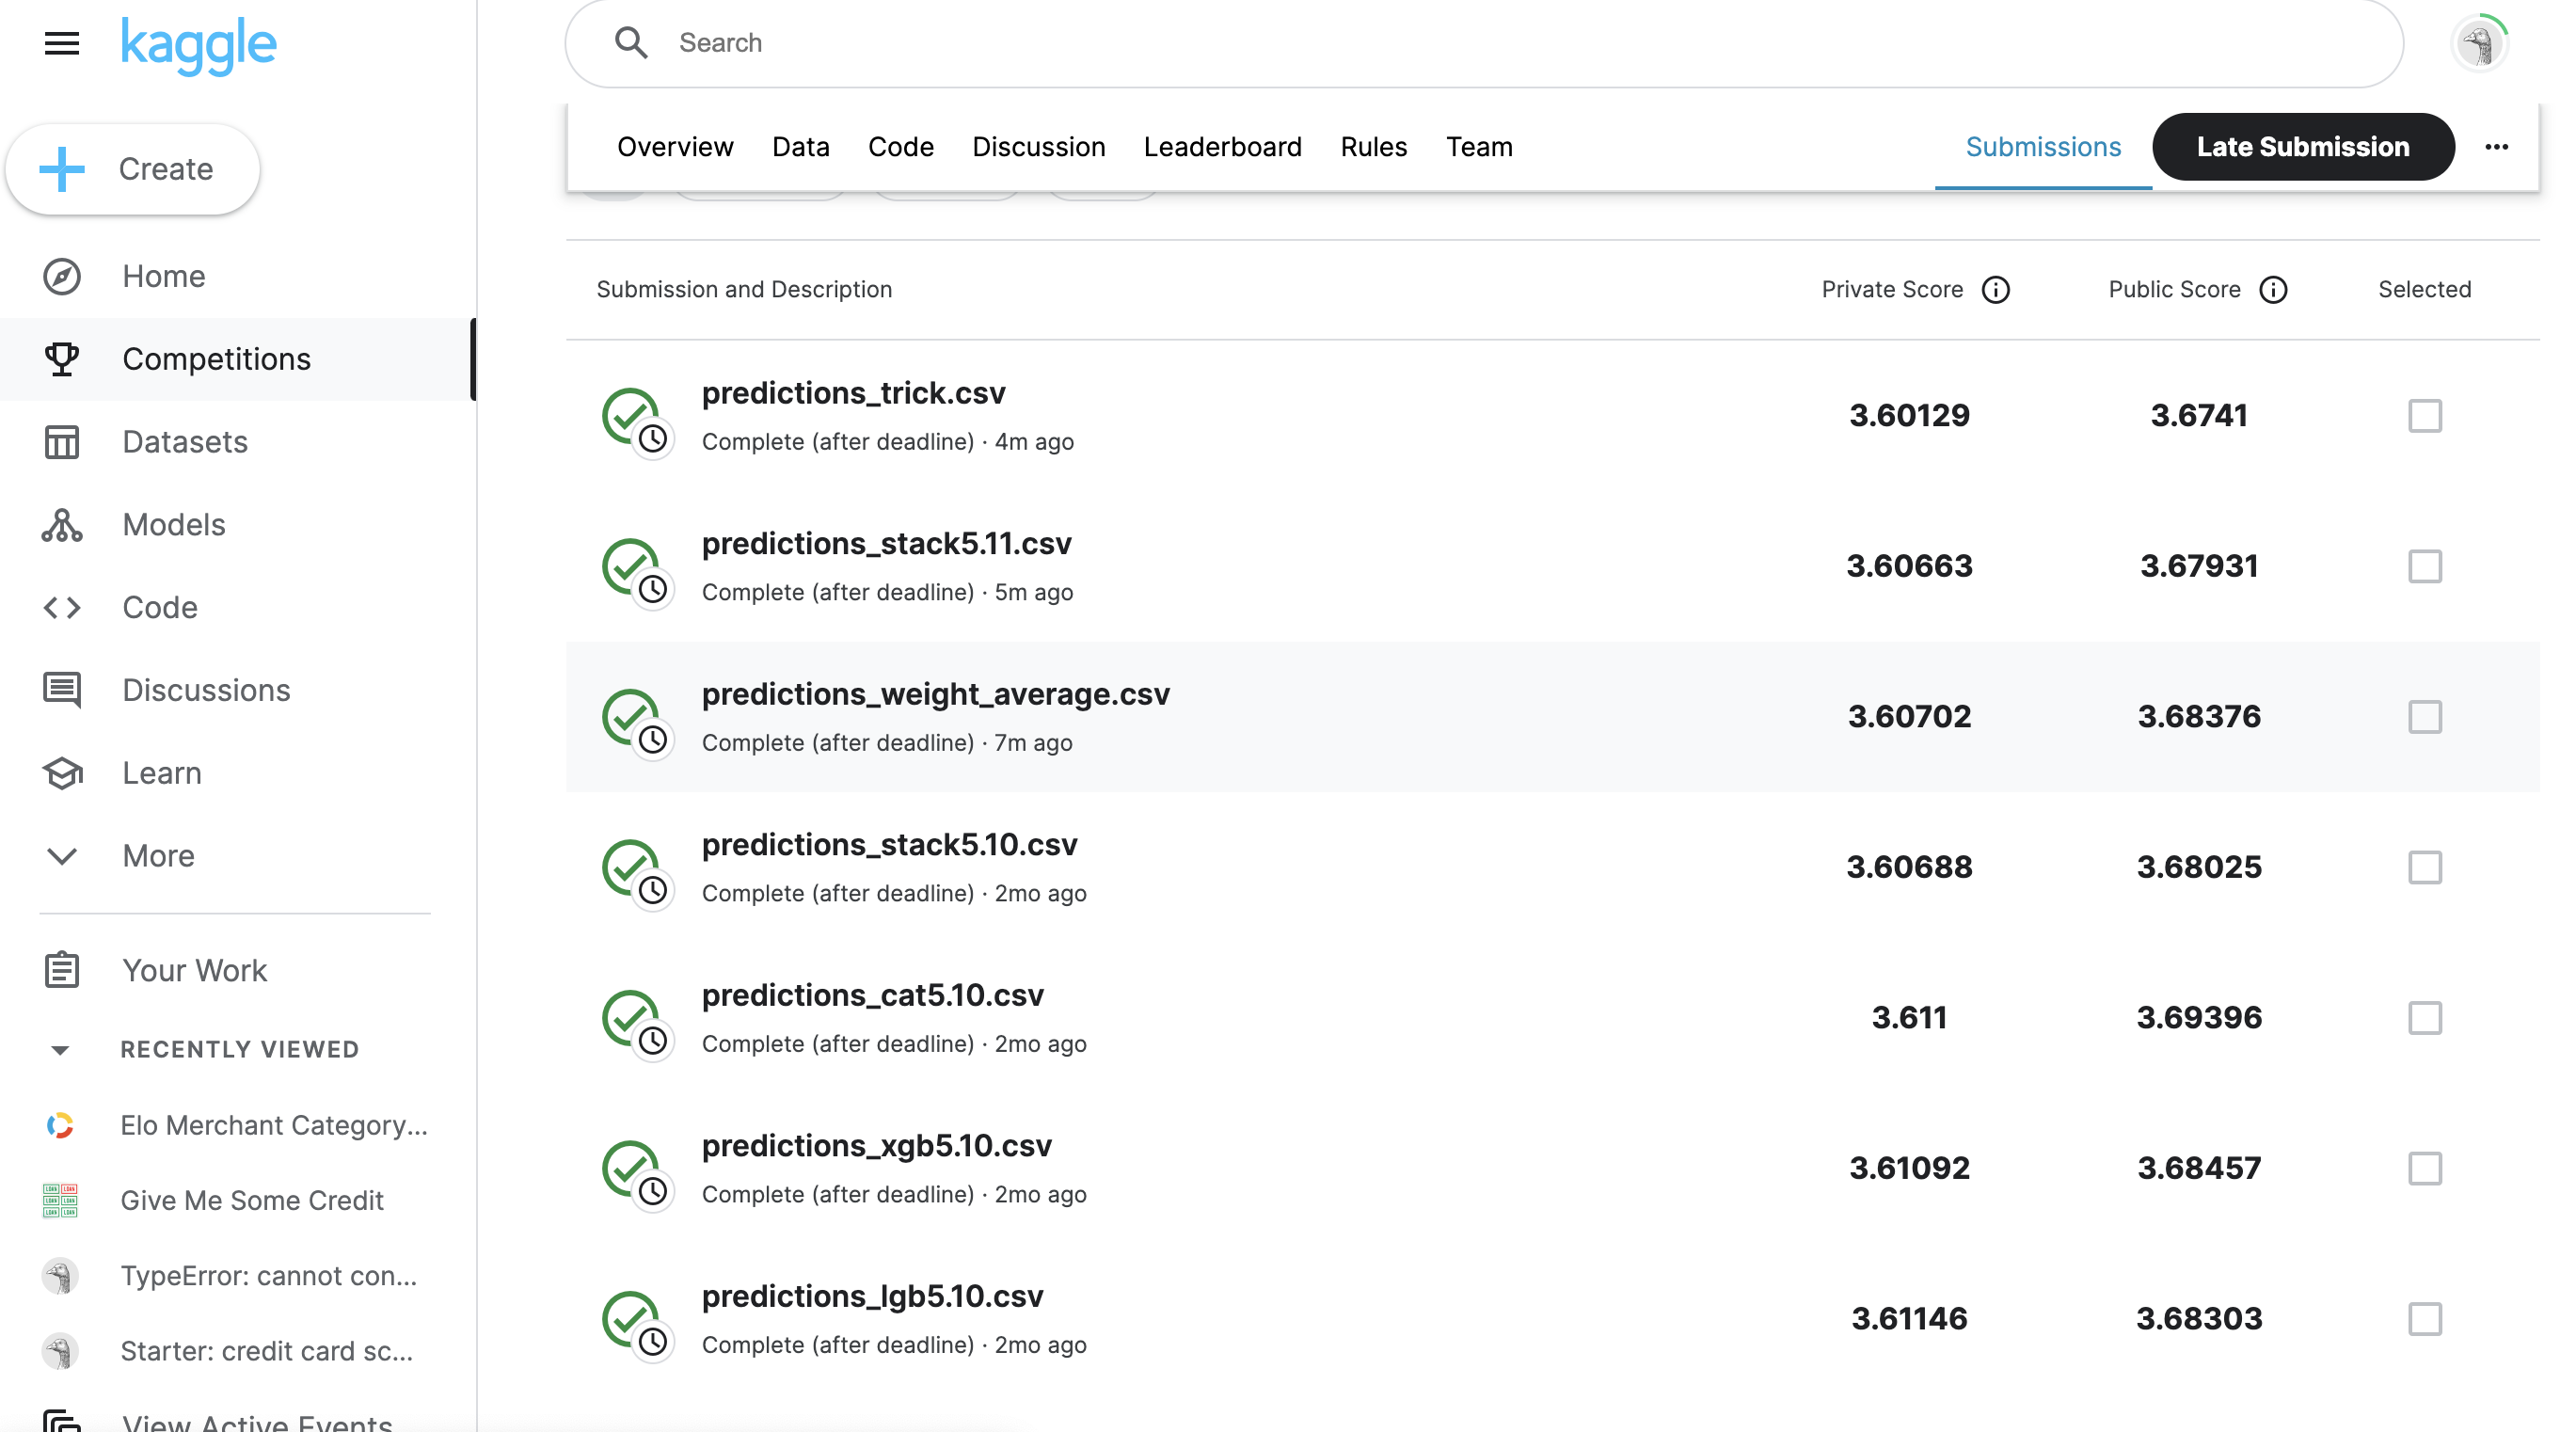

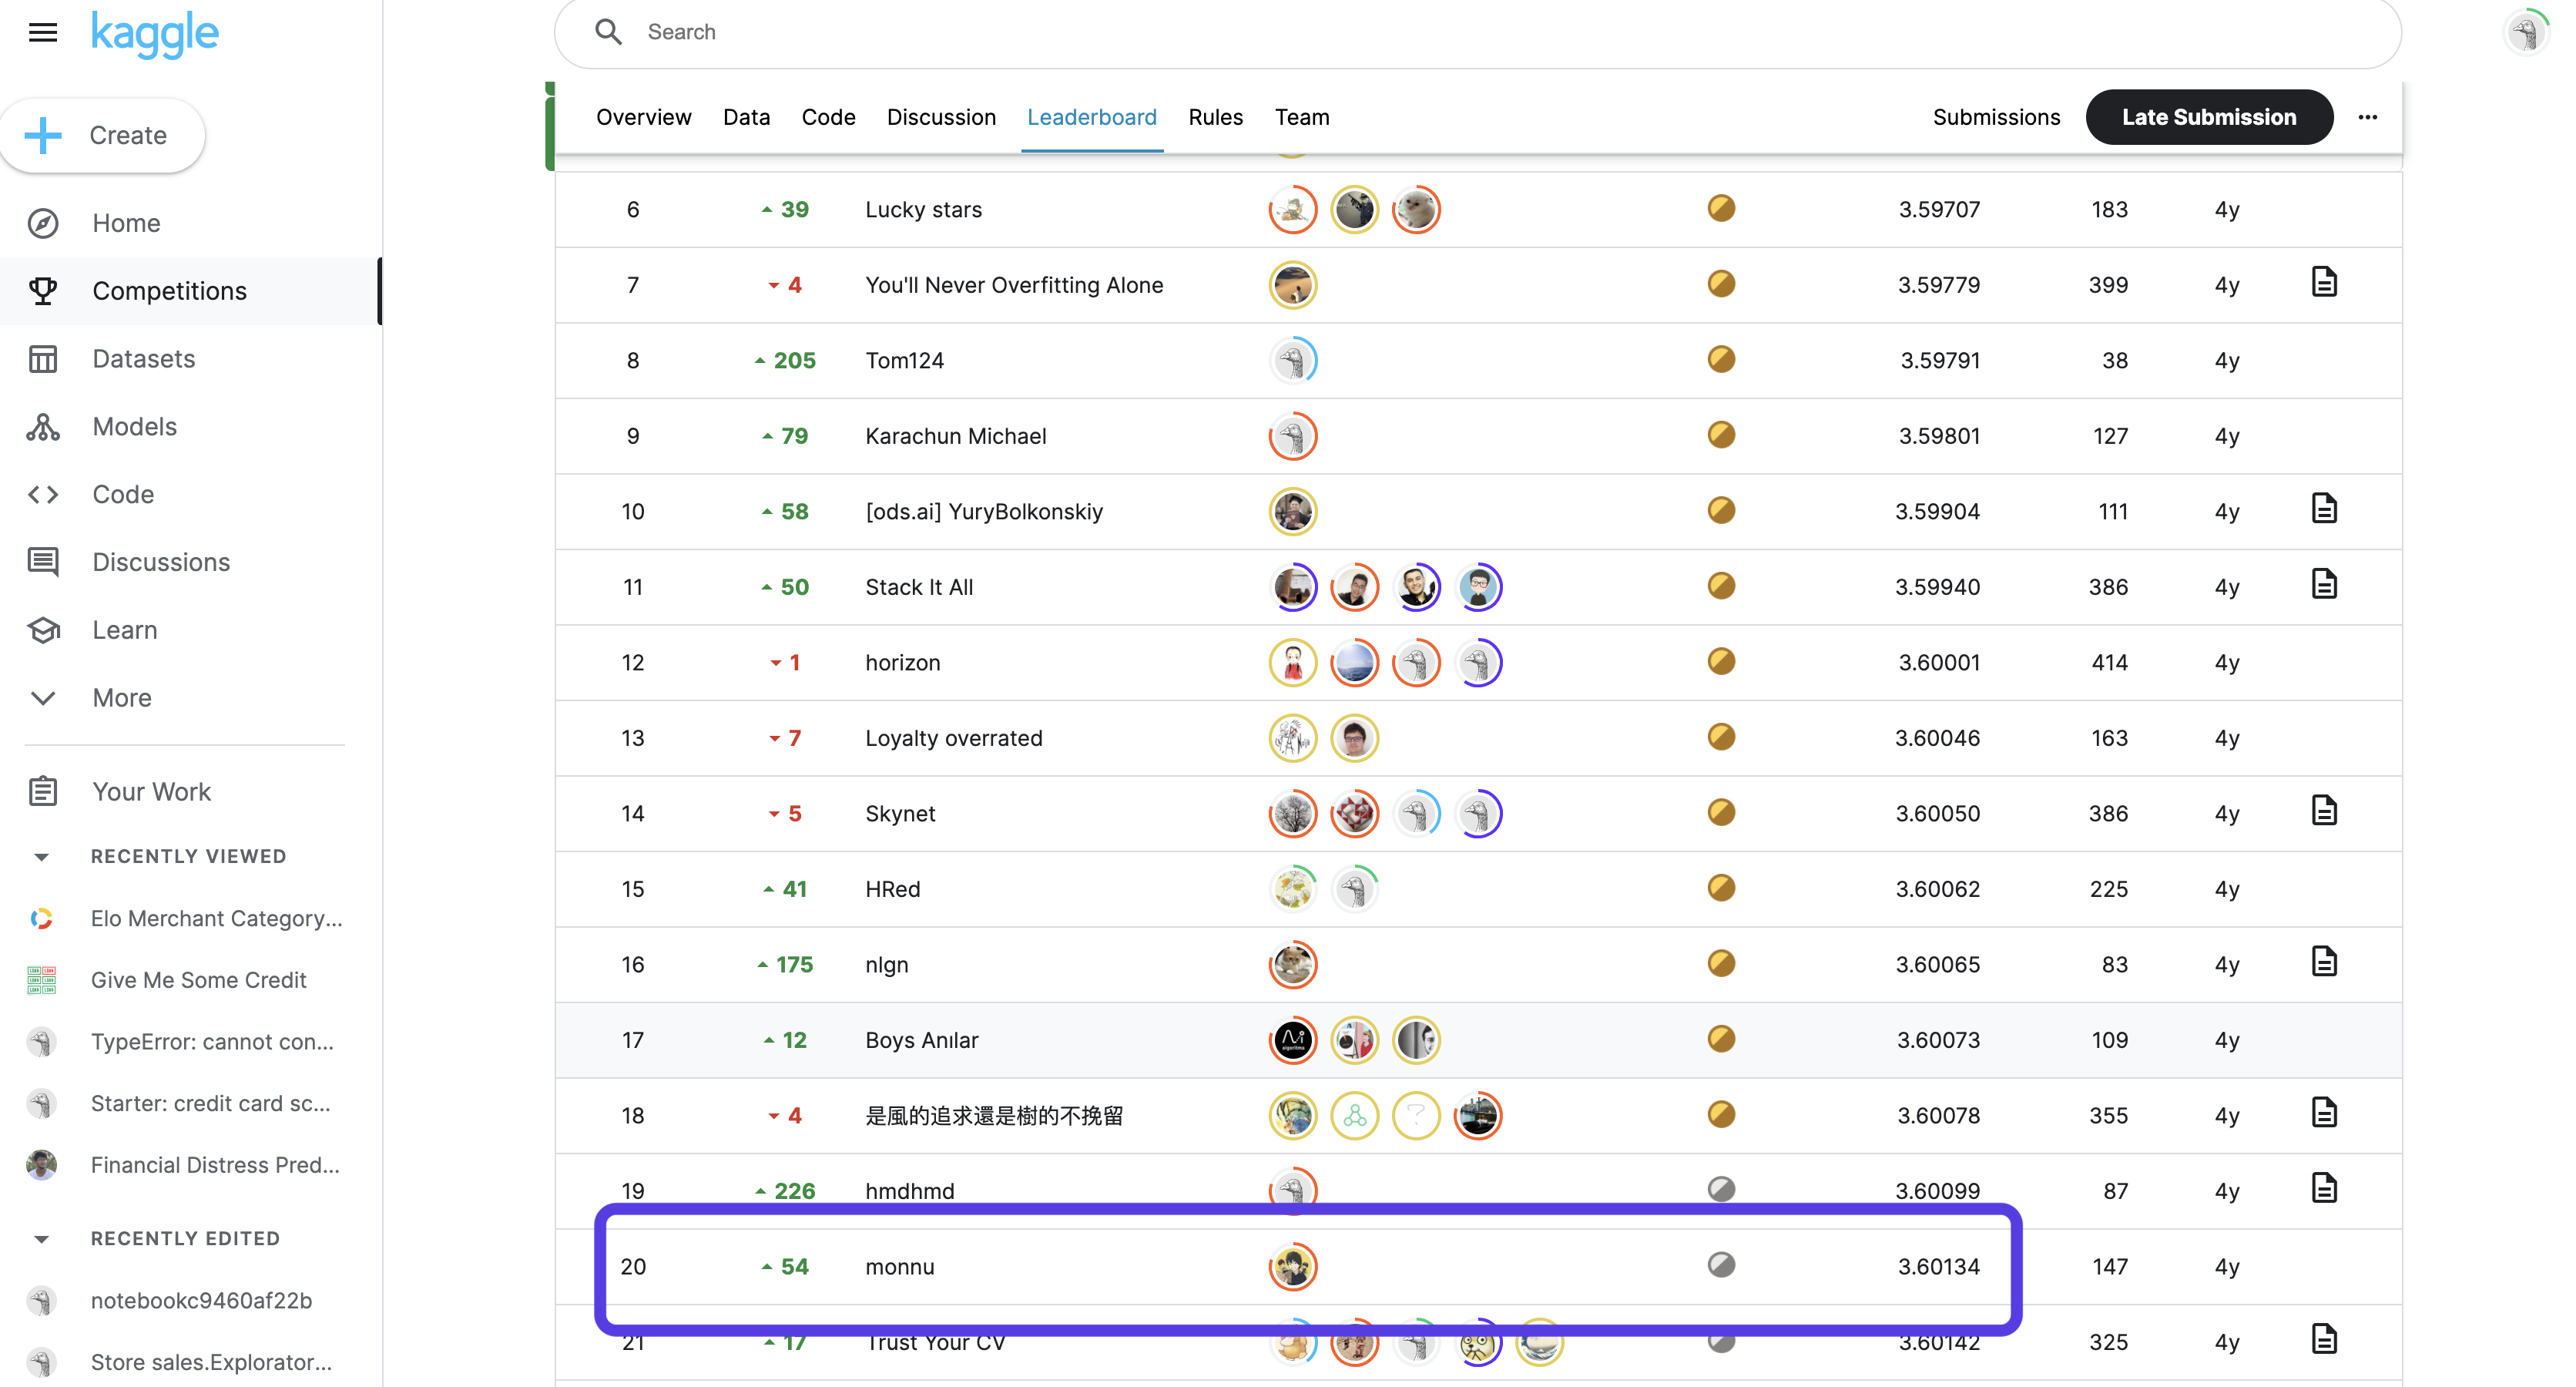